Install and Import Libraries

In [1]:

# Import medialpipe hands
!pip install -q flatbuffers==2.0.0
!pip install mediapipe
import cv2
import mediapipe as mp
import IPython
import pickle

# Import pytorch
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
print(torch.__version__)

# Import multiprocessing
import multiprocessing
from multiprocessing import Process, Value
print("Number of CPUs available: " + str(multiprocessing.cpu_count()))

out = display(IPython.display.Pretty('Starting'), display_id=True)

mp_hands = mp.solutions.hands


print("Put global variables here")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.17.1 requires flatbuffers>=24.3.25, but you have flatbuffers 2.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 21.7 MB/s eta 0:00:00
Looking in indexes: https://download.pytorch.org/whl/cu117
2.5.1+cu121
Number of CPUs available: 2


Starting

Put global variables here


Upload Network (weights)

In [13]:
#Code Used Here
#https://colab.research.google.com/github/googlesamples/mediapipe/blob/main/examples/hand_landmarker/python/hand_landmarker.ipynb#scrollTo=_JVO3rvPD4RN

import numpy as np
from google.colab import files
uploaded = files.upload()

for filename in uploaded:
  content = uploaded[filename]
  with open(filename, 'wb') as f:
    f.write(content)

if len(uploaded.keys()):
  DNN_FILE = next(iter(uploaded))
  print('Uploaded file:', DNN_FILE)

# Residual block for improved network
class ResidualBlock(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.BatchNorm1d(output_size),
            nn.PReLU(),
            nn.Linear(output_size, output_size),
            nn.BatchNorm1d(output_size),
        )
        self.shortcut = nn.Linear(input_size, output_size) if input_size != output_size else nn.Identity()

    def forward(self, x):
        return self.block(x) + self.shortcut(x)

# Standard Neural Network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(39, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 24),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Improved Neural Network with residual connections
class ResImprovedNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(39, 256),   # Input layer
            nn.BatchNorm1d(256),
            nn.PReLU(),
            nn.Dropout(0.3),

            ResidualBlock(256, 256),  # Residual block
            nn.Dropout(0.3),

            nn.Linear(256, 128),  # Transition layer
            nn.BatchNorm1d(128),
            nn.PReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),   # Compression layer
            nn.BatchNorm1d(64),
            nn.PReLU(),

            nn.Linear(64, 24),    # Output layer
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Choose model type based on the model file you're loading
# You can modify this to be a parameter or based on the filename
USE_IMPROVED_MODEL = True # Set to True if using the improved model

if USE_IMPROVED_MODEL:
    model = ResImprovedNeuralNetwork()
else:
    model = NeuralNetwork()

model.load_state_dict(torch.load(DNN_FILE, map_location=torch.device('cpu')))
model.eval()

Saving Advanced_Synthetic_Features2.pth to Advanced_Synthetic_Features2 (1).pth
Uploaded file: Advanced_Synthetic_Features2 (1).pth


<ipython-input-13-2eaf04b9f9ae>:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(DNN_FILE, map_location=torch.device('cpu')))


ResImprovedNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=39, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): Dropout(p=0.3, inplace=False)
    (4): ResidualBlock(
      (block): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
        (3): Linear(in_features=256, out_features=256, bias=True)
        (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Identity()
    )
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): PReLU(num_parameter

Upload Test Image

In [20]:
#Code Used Here
#https://colab.research.google.com/github/googlesamples/mediapipe/blob/main/examples/hand_landmarker/python/hand_landmarker.ipynb#scrollTo=_JVO3rvPD4RN

from google.colab import files
uploaded = files.upload()

for filename in uploaded:
  content = uploaded[filename]
  with open(filename, 'wb') as f:
    f.write(content)

if len(uploaded.keys()):
  IMAGE_FILE = next(iter(uploaded))
  print('Uploaded file:', IMAGE_FILE)

Saving test_o.png to test_o.png
Uploaded file: test_o.png


Inference of the Test Image

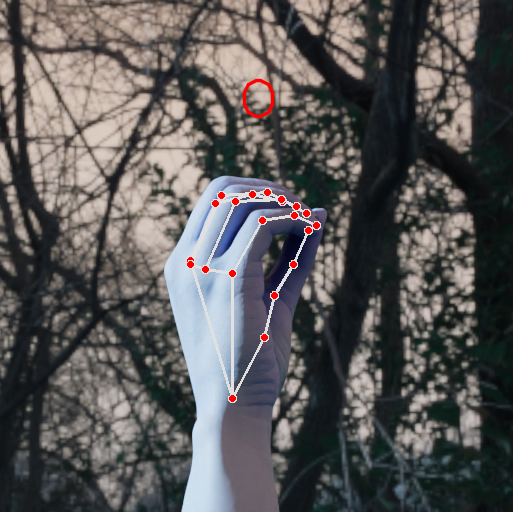

Predicted Letter: O
Confidence: 99.77%
Number of features: 39


In [21]:
#Code Used Here
#https://colab.research.google.com/github/googlesamples/mediapipe/blob/main/examples/hand_landmarker/python/hand_landmarker.ipynb#scrollTo=_JVO3rvPD4RN

# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2
from google.colab.patches import cv2_imshow
!wget -q https://storage.googleapis.com/mediapipe-tasks/hand_landmarker/hand_landmarker.task
from google.colab.patches import cv2_imshow
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

# STEP 2: Create an ImageClassifier object.
hands = mp_hands.Hands(
          static_image_mode=True,
          max_num_hands=1,
          min_detection_confidence=0.7)

# Create mapping dictionary for classifications
letter_map = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'K',
    10: 'L', 11: 'M', 12: 'N', 13: 'O', 14: 'P', 15: 'Q', 16: 'R', 17: 'S', 18: 'T',
    19: 'U', 20: 'V', 21: 'W', 22: 'X', 23: 'Y'
}

base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = cv2.flip(cv2.imread(IMAGE_FILE), 1)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# STEP 4: Detect hand landmarks from the input image.
detection = detector.detect(mp.Image.create_from_file(IMAGE_FILE))
detection_result = hands.process(image)

# STEP 5: Process the classification result. In this case, visualize it.
for hand_landmarks in detection_result.multi_hand_landmarks:
  mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

#Debug the output of Google Mediapipe
#cv2_imshow(image)

def coords_to_features(coordinates):

    label = []

    wrist = np.array([coordinates[0], coordinates[1], coordinates[2]])

    thumb_cmc = np.array([coordinates[3], coordinates[4], coordinates[5]])
    thumb_mcp = np.array([coordinates[6], coordinates[7], coordinates[8]])
    thumb_ip = np.array([coordinates[9], coordinates[10], coordinates[11]])
    thumb_tip = np.array([coordinates[12], coordinates[13], coordinates[14]])

    index_cmc = np.array([coordinates[15], coordinates[16], coordinates[17]])
    index_mcp = np.array([coordinates[18], coordinates[19], coordinates[20]])
    index_ip = np.array([coordinates[21], coordinates[22], coordinates[23]])
    index_tip = np.array([coordinates[24], coordinates[25], coordinates[26]])

    middle_cmc = np.array([coordinates[27], coordinates[28], coordinates[29]])
    middle_mcp = np.array([coordinates[30], coordinates[31], coordinates[32]])
    middle_ip = np.array([coordinates[33], coordinates[34], coordinates[35]])
    middle_tip = np.array([coordinates[36], coordinates[37], coordinates[38]])

    ring_cmc = np.array([coordinates[39], coordinates[40], coordinates[41]])
    ring_mcp = np.array([coordinates[42], coordinates[43], coordinates[44]])
    ring_ip = np.array([coordinates[45], coordinates[46], coordinates[47]])
    ring_tip = np.array([coordinates[48], coordinates[49], coordinates[50]])

    pinky_cmc = np.array([coordinates[51], coordinates[52], coordinates[53]])
    pinky_mcp = np.array([coordinates[54], coordinates[55], coordinates[56]])
    pinky_ip = np.array([coordinates[57], coordinates[58], coordinates[59]])
    pinky_tip = np.array([coordinates[60], coordinates[61], coordinates[62]])

    #Angle between finger joints
    #Thumb
    thumb_cmc_vec = np.subtract(thumb_cmc, wrist)
    thumb_mcp_vec = np.subtract(thumb_mcp, wrist)
    thumb_ip_vec = np.subtract(thumb_ip, wrist)
    thumb_tip_vec = np.subtract(thumb_tip, wrist)

    thumb_cmc_mcp_angle = np.dot(thumb_cmc_vec, thumb_mcp_vec) / np.linalg.norm(thumb_cmc_vec)
    thumb_cmc_mcp_angle /= np.linalg.norm(thumb_mcp_vec)
    thumb_cmc_mcp_angle = np.arccos(thumb_cmc_mcp_angle)

    thumb_mcp_ip_angle = np.dot(thumb_mcp_vec, thumb_ip_vec) / np.linalg.norm(thumb_mcp_vec)
    thumb_mcp_ip_angle /= np.linalg.norm(thumb_ip_vec)
    thumb_mcp_ip_angle = np.arccos(thumb_mcp_ip_angle)

    thumb_ip_tip_angle = np.dot(thumb_ip_vec, thumb_tip_vec) / np.linalg.norm(thumb_ip_vec)
    thumb_ip_tip_angle /= np.linalg.norm(thumb_tip_vec)
    thumb_ip_tip_angle = np.arccos(thumb_ip_tip_angle)

    #Index
    index_cmc_vec = np.subtract(index_cmc, wrist)
    index_mcp_vec = np.subtract(index_mcp, wrist)
    index_ip_vec = np.subtract(index_ip, wrist)
    index_tip_vec = np.subtract(index_tip, wrist)

    index_cmc_mcp_angle = np.dot(index_cmc_vec, index_mcp_vec) / np.linalg.norm(index_cmc_vec)
    index_cmc_mcp_angle /= np.linalg.norm(index_mcp_vec)
    index_cmc_mcp_angle = np.arccos(index_cmc_mcp_angle)

    index_mcp_ip_angle = np.dot(index_mcp_vec, index_ip_vec) / np.linalg.norm(index_mcp_vec)
    index_mcp_ip_angle /= np.linalg.norm(index_ip_vec)
    index_mcp_ip_angle = np.arccos(index_mcp_ip_angle)

    index_ip_tip_angle = np.dot(index_ip_vec, index_tip_vec) / np.linalg.norm(index_ip_vec)
    index_ip_tip_angle /= np.linalg.norm(index_tip_vec)
    index_ip_tip_angle = np.arccos(index_ip_tip_angle)

    #Middle
    middle_cmc_vec = np.subtract(middle_cmc, wrist)
    middle_mcp_vec = np.subtract(middle_mcp, wrist)
    middle_ip_vec = np.subtract(middle_ip, wrist)
    middle_tip_vec = np.subtract(middle_tip, wrist)

    middle_cmc_mcp_angle = np.dot(middle_cmc_vec, middle_mcp_vec) / np.linalg.norm(middle_cmc_vec)
    middle_cmc_mcp_angle /= np.linalg.norm(middle_mcp_vec)
    middle_cmc_mcp_angle = np.arccos(middle_cmc_mcp_angle)

    middle_mcp_ip_angle = np.dot(middle_mcp_vec, middle_ip_vec) / np.linalg.norm(middle_mcp_vec)
    middle_mcp_ip_angle /= np.linalg.norm(middle_ip_vec)
    middle_mcp_ip_angle = np.arccos(middle_mcp_ip_angle)

    middle_ip_tip_angle = np.dot(middle_ip_vec, middle_tip_vec) / np.linalg.norm(middle_ip_vec)
    middle_ip_tip_angle /= np.linalg.norm(middle_tip_vec)
    middle_ip_tip_angle = np.arccos(middle_ip_tip_angle)

    #Ring
    ring_cmc_vec = np.subtract(ring_cmc, wrist)
    ring_mcp_vec = np.subtract(ring_mcp, wrist)
    ring_ip_vec = np.subtract(ring_ip, wrist)
    ring_tip_vec = np.subtract(ring_tip, wrist)

    ring_cmc_mcp_angle = np.dot(ring_cmc_vec, ring_mcp_vec) / np.linalg.norm(ring_cmc_vec)
    ring_cmc_mcp_angle /= np.linalg.norm(ring_mcp_vec)
    ring_cmc_mcp_angle = np.arccos(ring_cmc_mcp_angle)

    ring_mcp_ip_angle = np.dot(ring_mcp_vec, ring_ip_vec) / np.linalg.norm(ring_mcp_vec)
    ring_mcp_ip_angle /= np.linalg.norm(ring_ip_vec)
    ring_mcp_ip_angle = np.arccos(ring_mcp_ip_angle)

    ring_ip_tip_angle = np.dot(ring_ip_vec, ring_tip_vec) / np.linalg.norm(ring_ip_vec)
    ring_ip_tip_angle /= np.linalg.norm(ring_tip_vec)
    ring_ip_tip_angle = np.arccos(ring_ip_tip_angle)

    #Pinky
    pinky_cmc_vec = np.subtract(pinky_cmc, wrist)
    pinky_mcp_vec = np.subtract(pinky_mcp, wrist)
    pinky_ip_vec = np.subtract(pinky_ip, wrist)
    pinky_tip_vec = np.subtract(pinky_tip, wrist)

    pinky_cmc_mcp_angle = np.dot(pinky_cmc_vec, pinky_mcp_vec) / np.linalg.norm(pinky_cmc_vec)
    pinky_cmc_mcp_angle /= np.linalg.norm(pinky_mcp_vec)
    pinky_cmc_mcp_angle = np.arccos(pinky_cmc_mcp_angle)

    pinky_mcp_ip_angle = np.dot(pinky_mcp_vec, pinky_ip_vec) / np.linalg.norm(pinky_mcp_vec)
    pinky_mcp_ip_angle /= np.linalg.norm(pinky_ip_vec)
    pinky_mcp_ip_angle = np.arccos(pinky_mcp_ip_angle)

    pinky_ip_tip_angle = np.dot(pinky_ip_vec, pinky_tip_vec) / np.linalg.norm(pinky_ip_vec)
    pinky_ip_tip_angle /= np.linalg.norm(pinky_tip_vec)
    pinky_ip_tip_angle = np.arccos(pinky_ip_tip_angle)

    #Euclidean distance
    thumb_tip_dist = np.linalg.norm(np.subtract(thumb_tip, wrist))
    thumb_cmc_dist = np.linalg.norm(thumb_cmc_vec)
    thumb_mcp_dist = np.linalg.norm(thumb_mcp_vec)
    thumb_ip_dist = np.linalg.norm(thumb_ip_vec)

    index_tip_dist = np.linalg.norm(np.subtract(index_tip, wrist))
    index_cmc_dist = np.linalg.norm(index_cmc_vec)
    index_mcp_dist = np.linalg.norm(index_mcp_vec)
    index_ip_dist = np.linalg.norm(index_ip_vec)

    middle_tip_dist = np.linalg.norm(np.subtract(middle_tip, wrist))
    middle_cmc_dist = np.linalg.norm(middle_cmc_vec)
    middle_mcp_dist = np.linalg.norm(middle_mcp_vec)
    middle_ip_dist = np.linalg.norm(middle_ip_vec)

    ring_tip_dist = np.linalg.norm(np.subtract(ring_tip, wrist))
    ring_cmc_dist = np.linalg.norm(ring_cmc_vec)
    ring_mcp_dist = np.linalg.norm(ring_mcp_vec)
    ring_ip_dist = np.linalg.norm(ring_ip_vec)

    pinky_tip_dist = np.linalg.norm(np.subtract(pinky_tip, wrist))
    pinky_cmc_dist = np.linalg.norm(pinky_cmc_vec)
    pinky_mcp_dist = np.linalg.norm(pinky_mcp_vec)
    pinky_ip_dist = np.linalg.norm(pinky_ip_vec)

    #Angles Between Fingers
    thumb_index_angle = np.dot(thumb_tip_vec, index_tip_vec) / (thumb_tip_dist*index_tip_dist)
    thumb_index_angle = np.arccos(thumb_index_angle)

    index_middle_angle = np.dot(index_tip_vec, middle_tip_vec) / (index_tip_dist*middle_tip_dist)
    index_middle_angle = np.arccos(index_middle_angle)

    middle_ring_angle = np.dot(middle_tip_vec, ring_tip_vec) / (middle_tip_dist*ring_tip_dist)
    middle_ring_angle = np.arccos(middle_ring_angle)

    ring_pinky_angle = np.dot(ring_tip_vec, pinky_tip_vec) / (ring_tip_dist*pinky_tip_dist)
    ring_pinky_angle = np.arccos(ring_pinky_angle)

    #Save to new csv file
    label.append(thumb_tip_dist)
    label.append(thumb_cmc_dist)
    label.append(thumb_mcp_dist)
    label.append(thumb_ip_dist)
    label.append(thumb_cmc_mcp_angle)
    label.append(thumb_mcp_ip_angle)
    label.append(thumb_ip_tip_angle)

    label.append(index_tip_dist)
    label.append(index_cmc_dist)
    label.append(index_mcp_dist)
    label.append(index_ip_dist)
    label.append(index_cmc_mcp_angle)
    label.append(index_mcp_ip_angle)
    label.append(index_ip_tip_angle)

    label.append(middle_tip_dist)
    label.append(middle_cmc_dist)
    label.append(middle_mcp_dist)
    label.append(middle_ip_dist)
    label.append(middle_cmc_mcp_angle)
    label.append(middle_mcp_ip_angle)
    label.append(middle_ip_tip_angle)

    label.append(ring_tip_dist)
    label.append(ring_cmc_dist)
    label.append(ring_mcp_dist)
    label.append(ring_ip_dist)
    label.append(ring_cmc_mcp_angle)
    label.append(ring_mcp_ip_angle)
    label.append(ring_ip_tip_angle)

    label.append(pinky_tip_dist)
    label.append(pinky_cmc_dist)
    label.append(pinky_mcp_dist)
    label.append(pinky_ip_dist)
    label.append(pinky_cmc_mcp_angle)
    label.append(pinky_mcp_ip_angle)
    label.append(pinky_ip_tip_angle)

    label.append(thumb_index_angle)
    label.append(index_middle_angle)
    label.append(middle_ring_angle)
    label.append(ring_pinky_angle)

    return label


try:
    # Process hand landmarks
    raw_coordinates = []

    # Get all landmarks from the first hand
    if detection.hand_world_landmarks and len(detection.hand_world_landmarks) > 0:
        first_hand = detection.hand_world_landmarks[0]
        for landmark in first_hand:
            raw_coordinates.extend([landmark.x, landmark.y, landmark.z])

    # Convert raw coordinates to features
    input_features = coords_to_features(raw_coordinates)

    # Convert to numpy array and reshape for batch dimension
    input_features = np.array(input_features, dtype=np.float32)
    input_features = input_features.reshape(1, -1)  # Add batch dimension

    # Convert to tensor
    input_tensor = torch.from_numpy(input_features).float()

    # Make prediction
    with torch.no_grad():
        result = model(input_tensor)
        probabilities = F.softmax(result, dim=1)  # Use dim=1 for batched input
        classification = torch.argmax(probabilities[0]).item()  # Take first batch result

    # Get predicted letter
    predicted_letter = letter_map[classification]

    # Add text to image
    text_position = (int(len(image)/2)-20, 120)
    cv2.putText(
        image,
        predicted_letter,
        text_position,
        cv2.FONT_HERSHEY_PLAIN,
        4,
        (0, 0, 255),
        2,
        cv2.LINE_AA
    )

    # Display result
    cv2_imshow(image)

    # Print confidence score and debug info
    confidence = probabilities[0][classification].item()
    print(f"Predicted Letter: {predicted_letter}")
    print(f"Confidence: {confidence:.2%}")
    print(f"Number of features: {len(input_features[0])}")

except Exception as e:
    print(f"Error during prediction: {str(e)}")
    print("Please ensure hand landmarks were properly detected in the image.")
    if 'raw_coordinates' in locals():
        print(f"Number of raw coordinates: {len(raw_coordinates)}")
    if 'input_features' in locals():
        print(f"Number of processed features: {len(input_features)}")
